<a href="https://colab.research.google.com/github/soroushmirzaei/text-processing-projects/blob/main/divan-mulana-text-generation/divan-mulana-text-generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import requirement libraries
import os
import shutil

#import dataset query libraries
import csv
import json

#import mathematics statics libraries
import random as rnd
import numpy as np
import pandas as pd

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning deep learning libraries
import tensorflow as tf
from tensorflow import keras


In [ ]:
#download filters-characters dataset
!wget -q https://raw.githubusercontent.com/soroushmirzaei/text-processing-projects/main/english-language-filter-characters.txt
!wget -q https://raw.githubusercontent.com/soroushmirzaei/text-processing-projects/main/persian-language-filter-characters.txt

#download similar-characters dataset
!wget -q https://raw.githubusercontent.com/soroushmirzaei/text-processing-projects/main/persian-language-similar-characters.json


In [ ]:
#define filters-list function loader
def filter_chars(file_path):
    filter_chars = list()
    with open(file_path, 'r') as filters_list_file:
        for word in filters_list_file:
            filter_chars.append(word.strip('\n'))
        filters_list_file.close()
    return filter_chars

#define similar-characters function loader
def similar_chars(file_path):
    with open(file_path, 'r') as similar_chars_file:
        similar_chars = json.load(similar_chars_file)
    return similar_chars


In [ ]:
#load filters-characters
eng_filter_characters = filter_chars('english-language-filter-characters.txt')
per_filter_characters = filter_chars('persian-language-filter-characters.txt')

#load similar-characters
per_similar_characters = similar_chars('persian-language-similar-characters.json')


In [ ]:
#define remove filters characters function
def remove_filter(text, filters_list):
    characters = list(text)
    characters_without_filters = [character for character in characters if character not in filters_list]
    text_without_filters = ''.join(characters_without_filters)
    return text_without_filters

#define similar characters modification function
def similar_char(text, similar_chars_dict):
    characters = list(text)
    similar_characters_modified_list = [similar_chars_dict.get(character,character) for character in characters]
    similar_characters_modified_text = ''.join(similar_characters_modified_list)
    return similar_characters_modified_text


In [ ]:
#define texts and labels list loader for csv and json files
def texts_loader(#define file path and type
                 file_path, file_type,
                 #define csv and txt files index for text and labels
                 text_index = None, header_row = True, spliter_delimiter = None,
                 #define json file keys for texts and labels
                 text_key = None,
                 #define preprocessing function for texts
                 use_filter_remover = False, filters_list = None,
                 use_similarchars_modifier = False, similarchars_dict = None
                 ):
    
    #create empty texts labels list
    texts_list = list()

    #csv file loader
    if file_type in ['csv']:
        with open(file_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter = spliter_delimiter)
            if header_row:
                next(csv_reader)
            for row in csv_reader:
                text = row[text_index]
                #optional modification function
                if use_filter_remover:
                    text = remove_filter(text, filters_list)
                if use_similarchars_modifier:
                    text = similar_char(text, similarchars_dict)
                texts_list.append(text)
        csv_file.close()

    #txt file loader
    if file_type in ['txt']:
        with open(file_path, 'r') as txt_file:
            for line in txt_file:
                line = line.split(spliter_delimiter)
                text = line[text_index]
                #optional modification function
                if use_filter_remover:
                    text = remove_filter(text, filters_list)
                if use_similarchars_modifier:
                    text = similar_char(text, similarchars_dict)
                texts_list.append(text.strip('\n'))
        txt_file.close()
    
    #json file loader
    if file_type in ['json']:
        with open(file_path, 'r') as json_file:
            json_reader = json.load(json_file)
            for item in json_reader:
                text = item[text_key]
                #optional modification function
                if use_filter_remover:
                    text = remove_filter(text, filters_list)
                if use_similarchars_modifier:
                    text = similar_char(text, similarchars_dict)
                texts_list.append(text)
        json_file.close()

    return texts_list


In [ ]:
texts = texts_loader(#define file path and type
                     file_path = '/content/divan-mulana-jalal-adin-rumi', file_type = 'txt',
                     #define csv and txt files index for text and labels
                     text_index = 0, spliter_delimiter = '\n',
                     use_filter_remover = True, filters_list = eng_filter_characters,
                     )

In [ ]:
texts[:10]

['Light',
 '',
 'I',
 '',
 '  Until the glorious Sun hath vanquished Night',
 '  The Birds of Day cower trembling with affright',
 '      But lo a bright glance bids the Tulip ope',
 '  O Heart awake thou too in Dutys might',
 '      The Suns Sword sheds in reddening flush of Dawn',
 '  The Blood of Night and puts the Foe to flight']

In [ ]:
#define tokenizer and sequences and padding sequences
def texts_labels_generator(#define texts
                           texts_list,
                           #define filter characters list
                           use_modified_filters = False, filters_list = None,
                           #define json tokenizer
                           save_tokenizer_json = False, tokenizer_filepath = None
                           ):
    
    #define tokenizer filters and fit on texts
    from keras.preprocessing.text import Tokenizer
    if use_modified_filters:
        filters = ''.join(filters_list)
    else:
        filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

    tokenizer = Tokenizer(filters = filters)
    tokenizer.fit_on_texts(texts_list)

    #define word_index
    word_index = tokenizer.word_index
    #for padding and counting out of vocab word
    total_words = len(word_index) + 1

    #save tokenizer json file
    if save_tokenizer_json:
        with open(tokenizer_filepath+'.json','w') as tokenizer_file:
            json.dump(tokenizer.to_json(), tokenizer_file)

    #define texts to sequences
    texts_sequences = tokenizer.texts_to_sequences(texts_list)

    #define phrase based sequences
    phrases_sequences = list()

    for text_sequence in texts_sequences:
        for token_iter in range(1, len(text_sequence)):
            phrase_sequence = text_sequence[:token_iter+1]
            phrases_sequences.append(phrase_sequence)

    #define maximum length of the sequences
    maxlen = max([len(sequence) for sequence in phrases_sequences])

    #define training validation pad sequences
    from keras.preprocessing.sequence import pad_sequences
    padded_sequences = pad_sequences(phrases_sequences, maxlen = maxlen, padding = 'pre')

    #split texts and labels
    texts = padded_sequences[:,:-1]
    labels = padded_sequences[:,-1]

    return texts, labels, maxlen, tokenizer, word_index


In [ ]:
texts, labels, maxlen, tokenizer, word_index = texts_labels_generator(#define texts
                                                                      texts_list = texts,
                                                                      #define filter characters list
                                                                      use_modified_filters = False, filters_list = None,
                                                                      #define json tokenizer
                                                                      save_tokenizer_json = False, tokenizer_filepath = None)


In [ ]:
texts

array([[  0,   0,   0, ...,   0,   0, 209],
       [  0,   0,   0, ...,   0, 209,   1],
       [  0,   0,   0, ..., 209,   1, 750],
       ...,
       [  0,   0,   0, ...,   0,   0,   7],
       [  0,   0,   0, ...,   0,   7, 102],
       [  0,   0,   0, ...,   7, 102,   3]], dtype=int32)

In [ ]:
labels

array([  1, 750,  48, ..., 102,   3,  14], dtype=int32)

In [ ]:
#define labels encoder
def label_encoder(#define labels list and method
                  labels_list,
                  #define method binary, ordinal or onehot
                  method, return_categories = True
                  ):
    
    #ordinal and binary encoder method
    if method in ['binary','ordinal']:
        unique_labels = sorted(list(set(labels_list)))
        labels_dict = {
            label : int(unique_labels.index(label)) for label in unique_labels
        }
        labels = list(map(lambda label : labels_dict[label], labels_list))
    
    #one-hot encoder method
    elif method in ['onehot']:
        unique_labels = sorted(list(set(labels_list)))
        labels_dict = {
            label : int(unique_labels.index(label)) for label in unique_labels
        }
        labels_encoded = list()
        for label in labels_list:
            label_encoded = len(unique_labels)*[0]
            label_number = labels_dict[label]
            label_encoded[label_number] = 1
            labels_encoded.append(label_encoded)
        labels = labels_encoded

    #convert list type to array
    labels_encoded = np.array(labels)
    
    if return_categories:
        return labels_encoded, labels_dict
    else:
        return labels_encoded
        

In [ ]:
labels_encoded, labels_dict = label_encoder(#define labels list and method
                                            labels_list = labels,
                                            #define method binary, ordinal or onehot
                                            method = 'onehot', return_categories = True
                                            )


In [ ]:
labels_encoded

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
labels_encoded.shape

(6631, 1983)

In [ ]:
#define pre-trained words dictionary loader
def word_dict_loader(#define file path and file type
                     file_path, file_type,
                     #define txt and csv file type args
                     word_index = None, vector_index = None, header = True, spliter_delimiter = None,
                     use_word_spliter = False, word_spliter = None, word_split_index = None,
                     #define json file type args
                     word_key = None, vector_key = None,
                     ):
    
    word_dict = dict()

    #define txt vec loader
    if file_type in ['txt', 'vec']:
        with open(file_path, 'r') as word_dict_file:
            if header:
                next(word_dict_file)
            for row in word_dict_file:
                row = row.split(spliter_delimiter)
                if use_word_spliter:
                    word = row[word_index].split(word_spliter)[word_split_index]
                else:
                    word = row[word_index]
                vectors = np.array(row[vector_index:], dtype = 'float32')
                word_dict[word] = vectors

    #define csv loader
    elif file_type in ['csv']:
        with open(file_path, 'r') as word_dict_file:
            word_dict_file = csv.reader(word_dict_file, delimiter = spliter_delimiter)
            if header:
                next(word_dict_file)
            for row in word_dict_file:
                if use_word_spliter:
                    word = row[word_index].split(word_spliter)[word_split_index]
                else:
                    word = row[word_index]
                vectors = np.array(row[vector_index:], dtype = 'float32')
                word_dict[word] = vectors
                
    #define json loader
    elif file_type in ['json']:
        with open(file_path, 'r') as word_dict_file:
            word_dict_file = json.load(word_dict_file)
            for item in word_dict_file:
                word = item[word_key]
                vectors = np.array(item[vector_key], dtype = 'float32')
                word_dict[word] = vectors

    #word dict params
    word_dict_size = len(word_dict)
    word_dict_dim = list(word_dict.values())[0].shape[0]

    return word_dict, word_dict_size, word_dict_dim


In [ ]:
#define pre-trained embedding word vectors
def embd_weights_loader(#define word dictionary and word index
                        word_dict, word_index, dimension
                        ):
    
    #create embedding weights
    embed_weights = np.zeros([len(word_index)+1, dimension])

    for word, index in word_index.items():
        if word in word_dict:
            embed_weights[index] = word_dict[word]

    #embedding layer params
    vocab_size = embed_weights.shape[0]
    embed_dim = embed_weights.shape[1]

    return embed_weights, vocab_size, embed_dim


In [ ]:
#define model
def create_model(#define input shape
                 input_shape = None,
                 #define embedding layer parameters
                 use_pretraind_embd = False, vocab_size = None, embd_dim = None,
                 sequence_len = None, embed_weights = None,
                 #define type of layer and parameters
                 use_lstm = False, use_gru = False, use_conv = False,
                 #define lstm layers parameters
                 lstm_layers_num = None, lstm_layers_units = None,
                 #define gru layers parameters
                 gru_layers_num = None, gru_layers_units = None,
                 #define convolution layers parameters
                 conv_layers_num = None, conv_layers_filters = None, conv_layers_kernel = None,
                 #define convolution layers sub layers
                 use_max_pool = False, max_pool_size = None,
                 #define dense layer feeder
                 use_global_max_pool = False, use_global_avg_pool = False, use_flatten = False,
                 use_feeder_dropout = False, feeder_dropout_ratio = None,
                 #define dense head layers
                 use_dense_layer = False, dense_layers_num = None, dense_layers_units = None,
                 #define dense layers dropout parameters
                 use_dense_dropout = False, dense_dropout_ratio = None,
                 #define output layer parameters
                 output_layer_unit = None, output_layer_activation = None,
                 #define model compiler parameters
                 optimizer = None, loss = None, metrics = None
                 ):
    
    #define input layer
    input = keras.Input(shape = input_shape)

    #define embedding layer and parameters
    if use_pretraind_embd:
        out = keras.layers.Embedding(input_dim = vocab_size, output_dim = embd_dim, input_length = sequence_len,
                                     weights = [embed_weights], trainable = False)(input)
    else:
        out = keras.layers.Embedding(input_dim = vocab_size, output_dim = embd_dim, input_length = sequence_len)(input)

    #define type of layer and parameters
    #lstm type layers
    if use_lstm:
        sequence_return = (lstm_layers_num - 1)*[True]
        sequence_return.append(False)
        for layer_num in range(lstm_layers_num):
            out = keras.layers.Bidirectional(keras.layers.LSTM(lstm_layers_units[layer_num],
                                                               return_sequences = sequence_return[layer_num]))(out)

    #gru type layers
    elif use_gru:
        sequence_return = (gru_layers_num - 1)*[True]
        sequence_return.append(False)
        for layer_num in range(gru_layers_num):
            out = keras.layers.Bidirectional(keras.layers.GRU(gru_layers_units[layer_num],
                                                              return_sequences = sequence_return[layer_num]))(out)
    
    #convolution type layer
    elif use_conv:
        for layer_num in range(conv_layers_num):
            out = keras.layers.Conv1D(filters = conv_layers_filters[layer_num], kernel_size = conv_layers_kernel[layer_num],
                                      activation = 'relu')(out)
            if use_max_pool[layer_num]:
                out = keras.layers.MaxPool1D(max_pool_size[layer_num])(out)


    #dense layers feeder layer
    #global max pool type layer
    if use_global_max_pool:
        out = keras.layers.GlobalMaxPooling1D()(out)
        
    #global average pool type layer
    elif use_global_avg_pool:
        out = keras.layers.GlobalAveragePooling1D()(out)

    #flatten type layer
    elif use_flatten:
        out = keras.layers.Flatten()(out)

    #define feeder dropout layer
    if use_feeder_dropout:
        out = keras.layers.Dropout(feeder_dropout_ratio)(out)


    #define dense head layers
    if use_dense_layer:
        for layer_num in range(dense_layers_num):
            out = keras.layers.Dense(dense_layers_units[layer_num], activation = 'relu')(out)
            if use_dense_dropout[layer_num]:
                out = keras.layers.Dropout(dense_dropout_ratio[layer_num])(out)
    
    #define output layer
    output = keras.layers.Dense(output_layer_unit, activation = output_layer_activation)(out)

    #define model
    model = keras.models.Model(inputs = input, outputs = output)


    #compile model
    model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics = metrics)
    
    return model
    

In [ ]:
model = create_model(#define input shape
                     input_shape = maxlen - 1,
                     #define embedding layer parameters
                     use_pretraind_embd = False, vocab_size = len(word_index) + 1 , embd_dim = 128,
                     sequence_len = maxlen - 1, embed_weights = None,
                     #define type of layer and parameters
                     use_lstm = True, use_gru = False, use_conv = False,
                     #define lstm layers parameters
                     lstm_layers_num = 2, lstm_layers_units = [64, 128],
                     #define gru layers parameters
                     gru_layers_num = None, gru_layers_units = None,
                     #define convolution layers parameters
                     conv_layers_num = None, conv_layers_filters = None, conv_layers_kernel = None,
                     #define convolution layers sub layers
                     use_max_pool = False, max_pool_size = None,
                     #define dense layer feeder
                     use_global_max_pool = False, use_global_avg_pool = False, use_flatten = False,
                     use_feeder_dropout = True, feeder_dropout_ratio = 0.2,
                     #define dense head layers
                     dense_layers_num = None, dense_layers_units = None,
                     #define dense layers dropout parameters
                     use_dense_dropout = False, dense_dropout_ratio = None,
                     #define output layer parameters
                     output_layer_unit = len(labels_dict), output_layer_activation = 'softmax',
                     #define model compiler parameters
                     optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy'
                     )

In [ ]:
#model summary
model.summary(120)


Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 input_1 (InputLayer)                                 [(None, 14)]                                    0                 
                                                                                                                        
 embedding (Embedding)                                (None, 14, 128)                                 270592            
                                                                                                                        
 bidirectional (Bidirectional)                        (None, 14, 128)                                 98816             
                                                                                                                        
 bidirectional_1 

In [ ]:
#fit model
model.fit(texts, labels_encoded, epochs = 500)


Epoch 1/500
208/208 [==============================] - 14s 11ms/step - loss: 6.8365 - accuracy: 0.0511
Epoch 2/500
208/208 [==============================] - 2s 11ms/step - loss: 6.3973 - accuracy: 0.0543
Epoch 3/500
208/208 [==============================] - 2s 11ms/step - loss: 6.2050 - accuracy: 0.0588
Epoch 4/500
208/208 [==============================] - 2s 11ms/step - loss: 6.0146 - accuracy: 0.0674
Epoch 5/500
208/208 [==============================] - 2s 11ms/step - loss: 5.8344 - accuracy: 0.0772
Epoch 6/500
208/208 [==============================] - 2s 11ms/step - loss: 5.6451 - accuracy: 0.0864
Epoch 7/500
208/208 [==============================] - 2s 11ms/step - loss: 5.4609 - accuracy: 0.0992
Epoch 8/500
208/208 [==============================] - 2s 11ms/step - loss: 5.2722 - accuracy: 0.1096
Epoch 9/500
208/208 [==============================] - 2s 11ms/step - loss: 5.0763 - accuracy: 0.1178
Epoch 10/500
208/208 [==============================] - 2s 11ms/step - loss: 4.87

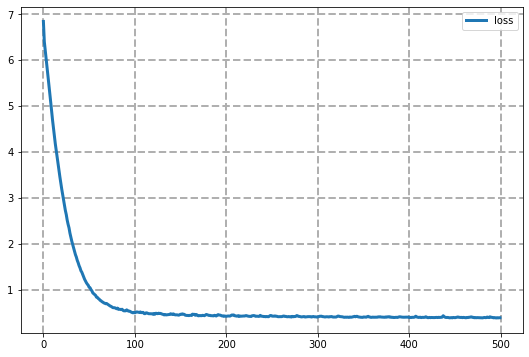

In [ ]:
#plot model training loss
pd.DataFrame(model.history.history)[['loss']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.show()


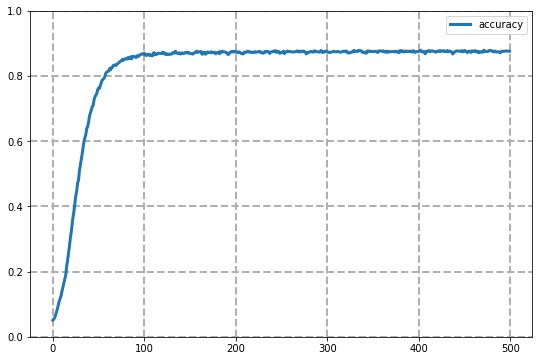

In [ ]:
#plot model training accuracy
pd.DataFrame(model.history.history)[['accuracy']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.ylim(0,1)
plt.show()


In [ ]:
#model evaluation
train_set_eval = model.evaluate(texts, labels_encoded, verbose = 0)
print(f'Training Set Evaluation:\n\tLoss: {round(train_set_eval[0],4)}\tAccuracy: {100*round(train_set_eval[1],4)}%')


Training Set Evaluation:
	Loss: 0.3418	Accuracy: 88.7%


In [ ]:
#define text generator based on model
def text_generator(#define text and numbert of iteration
                   input_text, iteration,
                   #define tokenizer and maxlen
                   tokenizer, maxlen, word_index,
                   #define labels categories and model
                   labels_dict, model, 
                   ):
    
    input_text = str(input_text)
    key_values_labels = dict([(key,value) for value, key in labels_dict.items()])
    index_word = dict([(key, value) for value, key in word_index.items()])

    for iter in range(iteration):
        text = tokenizer.texts_to_sequences([input_text])
        text = keras.preprocessing.sequence.pad_sequences(text, padding = 'pre', maxlen = maxlen - 1)
        predict = model.predict(text)
        predict = np.argmax(predict, axis = -1)[0]
        predict = key_values_labels[predict]
        predict = index_word[predict]
        input_text = input_text + " " + predict
    
    return input_text.title()


In [ ]:
#generate the text
generated_text = text_generator(#define text and numbert of iteration
                                input_text = 'We Never Die In Heart', iteration = 20,
                                #define tokenizer and maxlen
                                tokenizer = tokenizer, maxlen = maxlen, word_index = word_index,
                                #define labels categories and model
                                labels_dict = labels_dict, model = model,
                                )
#print out the generated text
print(generated_text)


We Never Die In Heart All Dreaming And Thought You There My Flame Hallelu Parting Close Look And East One God And Up And East


In [ ]:
#save model
model.save('/content/model.h5')
